In [1]:
# Check GPU environment
!nvidia-smi

Thu Dec 28 12:19:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.36                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    On  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8              18W /  80W |   6006MiB /  8192MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install dependency python packages
!pip install denoising_diffusion_pytorch -qq
!pip install datasets -qq

# Understand basic modules

In [3]:
# Create UNet and diffusion models

from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import torch

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000   # number of steps
).cuda()

/home/fw/miniconda3/envs/ai_painting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Train once on randomly initialized images
training_images = torch.randn(8, 3, 128, 128)
loss = diffusion(training_images.cuda())
loss.backward()

In [5]:
# Sample an image every 1000 steps
sampled_images = diffusion.sample(batch_size = 4)

sampling loop time step: 100%|██████████| 1000/1000 [01:10<00:00, 14.19it/s]


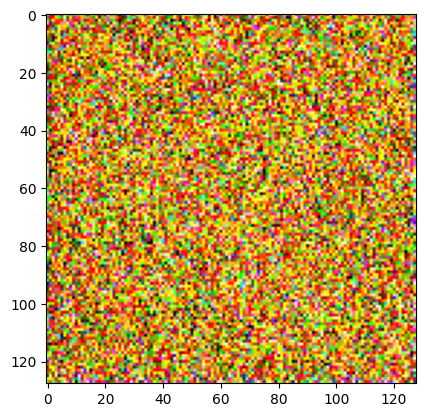

In [6]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms as transforms


# If tensor is on GPU, move to CPU
if sampled_images.is_cuda:
    sampled_images = sampled_images.cpu()

# Check the generated image
img = sampled_images[0].clone().detach().permute(1, 2, 0)

plt.imshow(img)

# Formal training

In [7]:
# Download dataset
from PIL import Image
from io import BytesIO
from datasets import load_dataset
import os
from tqdm import tqdm

dataset = load_dataset("nelorth/oxford-flowers")

# Create folder to save images
images_dir = "./oxford-datasets/raw-images"
os.makedirs(images_dir, exist_ok=True)

# Iterate through all images and save, around 15mins for oxford-flowers
for split in dataset.keys():
    for index, item in enumerate(tqdm(dataset[split])):
        image = item['image']
        image.save(os.path.join(images_dir, f"{split}_image_{index}.png"))

100%|██████████| 1020/1020 [01:33<00:00, 10.92it/s]


In [ ]:
# Model training
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000   # Total noise steps
).cuda()

trainer = Trainer(
    diffusion,
    './oxford-datasets/raw-images',
    train_batch_size = 16,
    train_lr = 2e-5,
    train_num_steps = 20000,          # Train for total 20,000 steps
    gradient_accumulate_every = 2,    # Gradient accumulation steps
    ema_decay = 0.995,                # Exponential moving average decay
    amp = True,                       # Use mixed precision training to accelerate
    calculate_fid = False,            # I turn off FID evaluation (time consuming). FID evaluates generation quality.
    save_and_sample_every = 2000      # Save model every 2,000 steps
)

trainer.train()

In [ ]:
# You can check generated results after above training finishes

from glob import glob

result_images = glob(r"./results/*.png")
print(result_images)

In [ ]:
# Visualize images
from PIL import Image

img = Image.open("./results/sample-1.png")
img